# Sparse GP Classification

## Model Description

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f \sim\mathcal{GP}_{\text{FITC}}(K, z_{1:M})$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$Y_n \sim \mathrm{Bernoulli}(\sigma(f))$,

where $K(x_1,x_2) = \exp\left(\beta - \sum_{d=1,2}\mathrm{softplus}({\alpha_d})\cdot(x_{1d} - x_{2d})^2\right)$.
<br>
Here, latent process $f\sim\mathcal{GP}_{\text{FITC}}(K, z_{1:M})$ is defined as:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$u=f_0\small{(z_{1:M})}$ for $f_0\sim\mathcal{GP}(K)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f(x)\sim\mathcal{GP}(K| f\small{(z_{1:M})}=u)$ <br>
Additionally, conditional independence of process $f$ among any points given $u=f_0\small{(z_{1:M})} = \left(f_0(z_1), ..., f_0(z_M)\right)$ is assumed. <br>
That is, for any $n_1$ and $n_2$, $f(x_{n_1})\perp \!\!\! \perp f(x_{n_1})|u$.

## Local Marginalization of Evidece Lower Bound
By simplifying notation as $f_{1:N} = f(x_{1:N})$ and $u = f(z_{1:M})$, we can write evidence lower bound (ELBO) and locally margianlized likelihood (LM-ELBO).

\begin{align}
\mathrm{LM}\text{-}\mathrm{ELBO}
&= \log p(y_{1:N}) - \mathrm{KL}\left[\ q(u)\ ||\ p(u|y_{1:N})\ \right] \\
&= \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&\geq \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)
- \mathrm{KL}\left[\ p(f_{1:N}|u)\ ||\ p(f_{1:N}| y_{1:N}, u)\ \right]\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \log p(y_{1:N}) - \mathrm{KL}\left[ p(f_{1:N}|u)q(u) || p(y_{1:N}, f_{1:N}, u) \right]\\
&= \mathrm{E}_{u\sim q} \mathrm{E}_{f_{1:N}\sim p(f_{1:N}|u)}\left[
\log \left(\frac{p(y_{1:N}, f_{1:N}, u)}{p(f_{1:N}| u)q(u)}\right) 
\right] \\
&= \sum_{n=1}^N\mathrm{E}_{u\sim q} \mathrm{E}_{f_n\sim p(f_n|u)}
\left[ \log p(y_n| f_n) \right] 
- \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \mathrm{ELBO}
\end{align}

### Possible Datasets
- http://archive.ics.uci.edu/ml/datasets/Adult
- http://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking
- http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
- http://archive.ics.uci.edu/ml/datasets/Buzz+in+social+media+

## Import Packages and Dataset

In [40]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [11]:
import tensorflow as tf
import numpy as np
np.random.seed(0)

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
import matplotlib
from matplotlib import pyplot as plt
import datetime

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [42]:
tf.test.is_gpu_available()

False

## Utilities

In [43]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Set Parameters

In [44]:
x = data.data
x = (x - x.mean(axis=0)) / x.std(axis=0) # standardization
y = data.target

In [45]:
N, D = x.shape
M = 30

In [46]:
def init_param(D, M):
    theta = {
    'z': tf.Variable(x[np.random.choice(np.arange(N), size=M, replace=False)]),
    'alpha': tf.Variable(np.ones([D]), dtype=tf.float64),
    'beta': tf.Variable(1., dtype=tf.float64)
    }
    phi = {
        'm': tf.Variable(np.zeros([M]), dtype=tf.float64),
        'CholS': tf.Variable(0.1*np.eye(M), dtype=tf.float64)
    }
    return theta, phi

In [47]:
def get_K(alpha, beta):
    # define Kernel
    D = alpha.shape[0]
    sp_alpha = tf.reshape( tf.math.softplus( alpha ), [1,1,D])
    def K(x1,x2):
        n1 = x1.shape[0]
        n2 = x2.shape[0]
        x1 = tf.reshape(x1, [n1, 1, D])
        x2 = tf.reshape(x2, [1 ,n2, D])
        return tf.exp(beta - tf.reduce_sum( sp_alpha*(x1-x2)**2, axis=2))
    return K

In [ ]:
def get_batch(batch_size=20):
    return x

## Logistic Regression as a Baseline 

In [60]:
model = LogisticRegression()
model.fit(x,y)
model.score(x,y)

0.9876977152899824

In [61]:
p = model.predict_proba(x)[:,1]
(y*np.log(p) + (1-y)*np.log(1-p)).mean()

-0.05339203990991728

## ELBO

In [48]:
def ELBO(x, y, theta, phi, N_total):
    '''
    Inputs:
    x: 2-d array of shape [N,D]
    y: 1-d array of shape [N]
    theta: disctionary of model parameters
    phi: disctionary of variational parameters
    
    Returns:
    elbo: scalar
    '''
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    CholS = phi['CholS']
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample()

    # compute ELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    elbo = tf.reduce_mean(p_y.log_prob(y)) - kl_qu_pu / N_total
    return elbo

In [49]:
def LMELBO(x, y, theta, phi, N_total, n_MC):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    CholS = phi['CholS']
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample(n_MC)

    # compute LMELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    log_prob_y = tf.reduce_mean( tf_logmeanexp( p_y.log_prob(y) , axis=0) ) 
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    lmelbo = log_prob_y - kl_qu_pu / N_total
    return lmelbo

In [50]:
def pointwise_dconditional_likelihood(x, y, theta, phi, level):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    CholS = phi['CholS']
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    n_MC = 2**level
    f = q_f.sample(n_MC)

    # compute ELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    w = p_y.log_prob(y)
    w = tf.reshape(w, [n_MC,N])
    if level==0:
        return tf_logmeanexp(w, axis=0) 
    else:
        return tf_logmeanexp(w, axis=0)\
                - (1/2.) * tf_logmeanexp(w[:n_MC//2 ], axis=0)\
                - (1/2.) * tf_logmeanexp(w[ n_MC//2:], axis=0)

In [51]:
theta, phi = init_param(D,M)

In [10]:
idx = np.repeat(np.arange(N), 10)
x_repeated = x[idx]
y_repeated = y[idx]

NameError: name 'np' is not defined

Text(0, 0.5, '$\\mathrm{E}||\\nabla\\ (\\Delta \\mathrm{LM}$-${ELBO})\\ ||_2^2$')

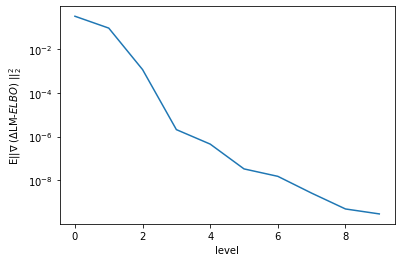

In [83]:
var_dcond_L = lambda l: (pointwise_dconditional_likelihood(x_tmp, y_tmp, theta, phi, level=l).numpy()**2).mean()
plt.plot([var_dcond_L(l) for l in range(10)])
plt.yscale('log')
plt.xlabel('level')
plt.ylabel(r'$\mathrm{E}||\nabla\ (\Delta \mathrm{LM}$-${ELBO})\ ||_2^2$') 

In [53]:
def dconditional_likelihood(x, y, mean_f, var_f, level):
    
    N = y.shape[0]
    # sample f_n's
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    n_MC = 2**level
    f = q_f.sample(n_MC)
    
    # sample conditional likelihoods
    p_y = tfp.distributions.Bernoulli(logits=f)
    w = p_y.log_prob(y)
    w = tf.reshape(w, [n_MC,N])
    
    if level==0:
        dL = tf_logmeanexp(w, axis=0) 
    else:
        dL = tf_logmeanexp(w, axis=0)\
                - (1/2.) * tf_logmeanexp(w[:n_MC//2 ], axis=0)\
                - (1/2.) * tf_logmeanexp(w[ n_MC//2:], axis=0)
    return tf.reduce_mean( dL )

In [54]:
def LMELBO_MLMC(x, y, theta, phi, N_total, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    """
    Compute IWELBO by MLMC
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    max_level: integer
    w0: the proportion of total samples in (x,y) used at the level 0.
        in other words, 100*(1-w0) % of the total samples are used for estimating the correction term.
    b: scalar. the second moment of the coupled difference estimator (dIWELBO) must decrease at a rate of O(2^(-b*level)).
    randomize: whether to use randomization of MLMC.
    
    Returns:
    iwelbo: scalar estimate of average iwelbo over sample points.
    """
    # unpack parameters
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    CholS = phi['CholS']
    
    # calculate KL divergence of p(u) and q(u) of u = f_0(z_1,...,z_M)
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
      
    # calculate distribution of f conditionally on u = f_0(z_1,...,z_M)
    u = q_u.sample(N)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    # determine proportions of the number of samples among levels
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    
    # determine the N_l's
    if randomize==True:
        Ns = np.random.multinomial(n=N, pvals=weights)    
    elif randomize==False:
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    # compute dIWELBO's using disjoint samples at each level and sum them up
    offset = 0
    lmelbo = kl_qu_pu / N_total
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[offset:offset+Ns[i]]
        y_tmp = y[offset:offset+Ns[i]]
        mean_f_tmp = mean_f[offset:offset+Ns[i]]
        var_f_tmp = var_f[offset:offset+Ns[i]]
                       
        if randomize==True:
            lmelbo += dconditional_likelihood(x_tmp, y_tmp, mean_f_tmp, var_f_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            lmelbo += dconditional_likelihood(x_tmp, y_tmp, mean_f_tmp, var_f_tmp, level=l)
    
        offset += Ns[i]
          
    return lmelbo

In [55]:
theta, phi = init_param(D, M)

In [56]:
optimizer = tf.keras.optimizers.Adam(0.05)

losses = []
for t in range(401):

    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - ELBO(x, y, theta, phi, 40000)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    losses.append(loss.numpy())
    if t%20==19:
        print('#iter: {}-{}\t{}'.format(t-19,t, np.mean(losses)))
        losses = []

#iter: 0-19	0.9908756272218187
#iter: 20-39	0.6517295144114708
#iter: 40-59	0.29828040918023996
#iter: 60-79	0.09494809144607715
#iter: 80-99	0.07056335120254617
#iter: 100-119	0.06497747820095827
#iter: 120-139	0.06124926035556031
#iter: 140-159	0.057582189851525536
#iter: 160-179	0.054847835008618395
#iter: 180-199	0.051817219559358904
#iter: 200-219	0.050372678756501844
#iter: 220-239	0.04826687438747719
#iter: 240-259	0.046858965889722846
#iter: 260-279	0.04421599513253066
#iter: 280-299	0.04236061000524271
#iter: 300-319	0.041309560973935046
#iter: 320-339	0.040624248888638394
#iter: 340-359	0.03923069317480163
#iter: 360-379	0.03829192465332126
#iter: 380-399	0.03845082724451372


In [57]:
theta, phi = init_param(D, M)

In [58]:
optimizer = tf.keras.optimizers.Adam(0.05)

losses = []
for t in range(401):

    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - LMELBO(x, y, theta, phi, 40000, n_MC=512)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    losses.append(loss.numpy())
    if t%20==19:
        print('#iter: {}-{}\t{}'.format(t-19,t, np.mean(losses)))
        losses = []

#iter: 0-19	0.6854190309795085
#iter: 20-39	0.5960468813278494
#iter: 40-59	0.2767951427118179
#iter: 60-79	0.08132688273993922
#iter: 80-99	0.048172801964581596
#iter: 100-119	0.03953503955640871
#iter: 120-139	0.03386698177437814
#iter: 140-159	0.031028669759984882
#iter: 160-179	0.028807662246323956
#iter: 180-199	0.026577446140311645
#iter: 200-219	0.02563881357130831
#iter: 220-239	0.02489525056327828
#iter: 240-259	0.02389808985647952
#iter: 260-279	0.022465886475968647
#iter: 280-299	0.02173163442931451
#iter: 300-319	0.021266342137426803
#iter: 320-339	0.020411976167229066
#iter: 340-359	0.01985767779640579
#iter: 360-379	0.01905878305407309
#iter: 380-399	0.01853264625626131


In [59]:
np.var([ELBO(x, y, theta, phi, N_total=10000) for x,y,_ in [generate_data(N, D, b0, b) for i in range(100)]])

NameError: name 'generate_data' is not defined

In [ ]:
np.var([LMELBO(x, y, theta, phi, N_total=10000, n_MC=2**10) for x,y,_ in [generate_data(N, D, b0, b) for i in range(100)]])

In [ ]:
np.var([LMELBO_MLMC(x, y, theta, phi, N_total=10000, max_level=10) for x,y,_ in [generate_data(N, D, b0, b) for i in range(100)]])

In [ ]:
np.mean([ELBO(x, y, theta, phi, N_total=10000) for x,y,_ in [generate_data(N, D, b0, b) for i in range(10)]])

In [ ]:
np.mean([LMELBO(x, y, theta, phi, N_total=10000, n_MC=2**10) for x,y,_ in [generate_data(N, D, b0, b) for i in range(10)]])

In [ ]:
np.mean([LMELBO_MLMC(x, y, theta, phi, N_total=10000, max_level=10) for x,y,_ in [generate_data(N, D, b0, b) for i in range(10)]])

In [ ]:
%%timeit
ELBO(x, y, theta, phi, N_total=10000)

In [ ]:
%%timeit
LMELBO(x, y, theta, phi, N_total=10000, n_MC=2**10)

In [ ]:
%%timeit
LMELBO_MLMC(x, y, theta, phi, N_total=10000, max_level=10, randomize=True)

## Parameter Estimation

In [ ]:
theta, phi = init_param(D, M)

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.05)

losses = []
for t in range(401):
    x,y,_ = generate_data(N, D, b0, b)

    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - ELBO(x, y, theta, phi, 40000)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    losses.append(loss.numpy())
    if t%20==19:
        print('#iter: {}-{}\t{}'.format(t-19,t, np.mean(losses)))
        losses = []

In [ ]:
theta, phi = init_param(D, M)

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.05)

losses = []
for t in range(401):
    x,y,_ = generate_data(N, D, b0, b)

    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - LMELBO(x, y, theta, phi, 40000, n_MC=64)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    losses.append(loss.numpy())
    if t%20==19:
        print('#iter: {}-{}\t{}'.format(t-19,t, np.mean(losses)))
        losses = []

## Learning Curve by Different Methods

In [ ]:
lambda x1, x2 = (gamma * tf.reduce_sum(x1*x2) + coef0)^degree


・Test LMELBO をプロットしないと意味ない<br>
・<s>MNISTで、バッチサイズ小さめで検証</s>←カーネルの計算が重いと死ぬ<br>
・潜在変数のサンプルは$\mathcal{O}(1)$。各データ点の処理は$\mathcal{O}(M^2)$という致命的な問題がある。<br>
・MLMCは潜在変数のサンプリングコストが支配的なときに使うもの。<br>
・かと言って、潜在変数の空間が複雑だと、カップリングしないという問題もある。

結論…$M$を固定して、Small Dataでなんとか頑張って優位性を示す

In [ ]:
def get_mlmc_cost(N, max_level, b, w0):
    # compute the cost of MLMC estimation 
    # when the size of x (and that of y) is N
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    cost = np.ceil(N * weights[0])\
            + N * sum( np.ceil(weights[1:] * (2**levels[1:] + 2**(levels[1:]-1))) )
    return cost

In [ ]:
objectives = {
    "elbo":      lambda x, y, theta, phi: ELBO(x, y, theta, phi, N_total=40000),
    "lmelbo8":   lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=8),
    "lmelbo64":  lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=64),
    "lmelbo512": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=512),
    "lmelbo512_mlmc": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=512),
    "lmelbo512_randmlmc": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=512),
}

n_repeat = 10
results = {}

for name, obj in objectives.items():
    loss_seqs = []
    for i in range(n_repeat):
        print("training {}.... #iter:{} ".format(name,i))
        optimizer = tf.keras.optimizers.Adam(0.05)
        theta, phi = init_param(D,M)
        loss_seq = []
        
        for t in range(400):
            x,y,_ = generate_data(N, D, b0, b)

            # balance the cost of mlmc and nmc when level=9 (n_MC=512)
            if 'mlmc' in name:
                cost_nmc  = N * 2**9
                cost_mlmc = get_mlmc_cost(N, max_level=9, b=1.8, w0=0.9)
                N_mlmc = np.math.ceil(N * (cost_nmc / cost_mlmc))
                x,y,_ = generate_data(N_mlmc, D, b0, b)
            
            # Optimize
            with tf.GradientTape() as g:
                g.watch([theta, phi])
                loss = - obj(x, y, theta, phi)
            dtheta, dphi = g.gradient(loss, [theta, phi])
            gradients = list(dtheta.values()) + list(dphi.values())
            variables = list(theta.values()) + list(phi.values())
            optimizer.apply_gradients(zip(gradients, variables))

            loss_seq.append(loss.numpy())
        loss_seqs.append(loss_seq) 
    results[name] = np.array(loss_seqs)
    print()

In [ ]:
import pickle

In [ ]:
#with open('../out/gaussian_process_classification/train_log_{}.pickel'.format(timestamp()), 'wb') as file:
#    pickle.dump(results, file)

In [ ]:
plt.figure(figsize=[15,6])
for logs in results.values():
    plt.plot(logs.mean(axis=0), alpha=0.5)
plt.legend([name for name in results])
plt.ylim([0.54, 0.66])

In [2]:
import sys
sys.path.append('../')
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
x = data.data
x = (x - x.mean(axis=0)) / x.std(axis=0) # standardization
y = data.target

In [3]:
import numpy as np

In [4]:
idx = np.repeat(np.arange(x.shape[0]), 100)
x_repeated = x[idx]
y_repeated = y[idx]

In [5]:
from src.models.gaussian_process_classification import gaussian_process_classification

In [20]:
gpc = gaussian_process_classification(N_total=x.shape[0])

gpc.fit(x,y, learning_rate=0.05, n_iter=401, objective='LMELBO', obj_param={'n_MC':512})

In [27]:
gpc = gaussian_process_classification(N_total=x.shape[0])

In [28]:
gpc.fit(x_repeated,y_repeated, learning_rate=0.05, n_iter=801, objective='LMELBO_MLMC', obj_param={'max_level':4})

#iter: 0-39	0.9103086106193434
#iter: 40-79	0.3121191711189633
#iter: 80-119	0.1408094033981439
#iter: 120-159	0.11529590468374781
#iter: 160-199	0.10600360130249006
#iter: 200-239	0.10123168054719636
#iter: 240-279	0.09878783229470545
#iter: 280-319	0.09326860354120677
#iter: 320-359	0.0943860912112944
#iter: 360-399	0.09125513406476582
#iter: 400-439	0.09153052216153348
#iter: 440-479	0.09026237338266595
#iter: 480-519	0.08789725932350241
#iter: 520-559	0.0824310066834962
#iter: 560-599	0.09229420343429333
#iter: 600-639	0.08733396526812014
#iter: 640-679	0.08732555802368795
#iter: 680-719	0.09056797987932697
#iter: 720-759	0.08303010629177308
#iter: 760-799	0.0877699344604479


In [44]:
gpc.fit(x_repeated,y_repeated, learning_rate=0.05, n_iter=801, objective='LMELBO_MLMC', obj_param={'max_level':4})

#iter: 0-39	0.08274774968376963
#iter: 40-79	0.07997856359173965
#iter: 80-119	0.08467681759755301
#iter: 120-159	0.08335285793519029
#iter: 160-199	0.08318149374294229
#iter: 200-239	0.08330375782456594
#iter: 240-279	0.08256526782674906
#iter: 280-319	0.08013478628508147
#iter: 320-359	0.07875466101493026
#iter: 360-399	0.08111813541810588
#iter: 400-439	0.07737263113508
#iter: 440-479	0.07685041294596309
#iter: 480-519	0.07893655498021808
#iter: 520-559	0.07721814839399085
#iter: 560-599	0.08038779611559896
#iter: 600-639	0.07904832126372296
#iter: 640-679	0.07754442940794096
#iter: 680-719	0.08025222145486971
#iter: 720-759	0.0774671159122188
#iter: 760-799	0.07573900150769121


In [30]:
gpc.score(x_repeated,y_repeated,objective='LMELBO_MLMC', obj_param={'max_level':4})

<tf.Tensor: shape=(), dtype=float64, numpy=-0.07471497931132799>

In [31]:
gpc.score(x,y,objective='LMELBO', obj_param={'n_MC':16})

<tf.Tensor: shape=(), dtype=float64, numpy=-0.08438146992660227>

In [45]:
gpc.score(x_repeated,y_repeated)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.04782105083088791>

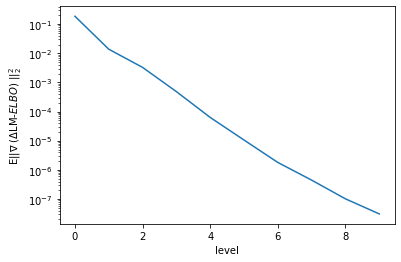

In [10]:
gpc.plot_convergence(x_repeated, y_repeated, max_level=10)